In [7]:
# from Algorithm 1: HMC, page1353
def Leapfrog(theta, r, grad, eps, L):
    r_tilde = r + (eps/2) * grad
    theta_tilde = theta + eps * r_tilde
    logp_tilde, grad_tilde = L(theta_tilde)
    r_tilde = r_tilde + (eps/2) * grad_tilde
    return theta_tilde, r_tilde, grad_tilde, logp_tilde

In [8]:
def FindReasonableEpsilon(theta, grad, logp, L):
    #initialize
    parems = len(theta)
    eps = 1
    r = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
    r = r.ravel()
    theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L)
    
    prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r, r)))
    a = 2 * int(prob > 0.5) - 1

    while prob**a > 2**(-a):
        eps = 2**a * eps
        theta_prime, r_prime, _, logp_prime = Leapfrog(theta, r, grad, eps, L);
        prob = np.exp(logp_prime - logp - 0.5 * (np.dot(r_prime, r_prime) - np.dot(r,r)))
    return eps

In [9]:
def BuildTree(theta, r, grad, u, v, j, eps, L, esto0):
    if j == 0: 
        # base case, take one leapfrog step in the direction v
        theta_prime, r_prime, grad_prime, logp_prime = Leapfrog(theta, r, grad, v*eps, L)
        
        esto = logp_prime - 0.5 * np.dot(r_prime, r_prime)

        n_prime = int(u <= np.exp(esto))
        
        s_prime = int(esto > np.log(u) - 1000)

        alpha_prime = min(1, np.exp(esto - esto0))
                                                   
        return theta_prime, r_prime, grad_prime, theta_prime, r_prime, grad_prime, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, 1
    else:
        # recursion, build left and right subtrees
        theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime = BuildTree(theta, r, grad, u, v, j-1, eps, L, esto0)
        
        if s_prime == 1:
            if v == -1:
                theta_minus, r_minus, grad_minus, _,_,_, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_minus, r_minus, grad_minus, u, v, j-1, eps, L, esto0)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_doub_prime, grad_doub_prime, logp_doub_prime, n_doub_prime, s_doub_prime, alpha_doub_prime, n_alpha_doub_prime = BuildTree(theta_plus, r_plus, grad_plus, u, v, j-1, eps, L, esto0)

            # Use Metropolis-Hastings
            prob = n_doub_prime / max(n_prime + n_doub_prime,1)
            if (np.random.uniform(0, 1, 1) < prob):
                theta_prime = theta_doub_prime
                grad_prime = grad_doub_prime
                logp_prime = logp_doub_prime
            
            ind_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            ind_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s_prime = s_prime * s_doub_prime * ind_1 * ind_2
            n_prime = n_prime + n_doub_prime
            alpha_prime = alpha_prime + alpha_doub_prime
            n_alpha_prime = n_alpha_prime + n_alpha_doub_prime
        
        return theta_minus, r_minus, grad_minus, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha_prime, n_alpha_prime

In [11]:
def nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6):
    # initialize samples matrix
    # put initial theta0 in first row of matrix
    parems = len(theta0)
    samples = np.empty((M+1, parems))
    samples[0, :] = theta0
    logp, grad = L(theta0)
    eps = FindReasonableEpsilon(theta0, grad, logp, L)
    mu = np.log(10*eps)
    eps_bar = 1
    H_bar = 0
    gamma = 0.05
    t0 = 10
    k = 0.75
    
    for m in range(1, M+1):
        # resample
        norm_samp = np.random.multivariate_normal(np.zeros(parems), np.identity(parems), 1)
        r0 = norm_samp.ravel()

        esto = logp - 0.5 * np.dot(r0,r0)
        # resample u ~ uniform([0, exp(inside)])
        u = np.random.uniform(0, np.exp(esto), 1)

        # initialize minus's and plus's
        theta_minus = samples[m-1, :]
        theta_plus = samples[m-1, :]
        r_minus = r0
        r_plus = r0
        j = 0
        grad_minus = grad
        grad_plus = grad
        
        j = 0
        samples[m, :] = samples[m-1, :]
        n = 1
        s = 1
        
        while s == 1:
            v_j = np.random.uniform(-1,1,1)
            if v_j == -1:
                theta_minus, r_minus, grad_minus, _, _, _, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_minus, r_minus, grad_minus, u, v_j, j, eps, L, esto)
            else:
                _, _, _, theta_plus, r_plus, grad_plus, theta_prime, grad_prime, logp_prime, n_prime, s_prime, alpha, n_alpha = BuildTree(theta_plus, r_plus, grad_plus, u, v_j, j, eps, L, esto)
            
            if s_prime == 1:
                # Use Metropolis-Hastings
                prob = min(1, n_prime/n)
                if (np.random.uniform(0,1,1) < prob):
                    samples[m, :] = theta_prime
                    logp = logp_prime
                    grad = grad_prime
                    
            n = n + n_prime

            boolean_1 = int(np.dot(theta_plus-theta_minus, r_minus) >= 0)
            boolean_2 = int(np.dot(theta_plus-theta_minus, r_plus) >= 0)
            s = s_prime * boolean_1 * boolean_2
            j = j + 1
            
        if m <= M_adapt:
            H_bar = (1 - 1/(m+t0))*H_bar + (1/(m+t0)) * (delta - alpha/n_alpha)
            eps = np.exp(mu - np.sqrt(m)/gamma * H_bar)
            esp_bar = np.exp(m**(-k) * np.log(eps) + (1-m**(-k))*np.log(eps_bar))
        else:
            eps = eps_bar
            
    burned_in = samples[M_adapt+1:M+1, :]
    return samples, burned_in

In [10]:
X = np.random.poisson(5, 100)
N = 100
def L(theta):
    grad = sum(X) / theta - N
    logp = sum(X)*np.log(theta) - theta*N
    return logp, grad
np.mean(X)

5.1900000000000004

In [12]:
# simple example
theta0 = np.array([10])
M = 10000
M_adapt = 1000
samples, burned_in = nuts6_dual_averaging(theta0, M, M_adapt, L, delta = 0.6)
np.mean(burned_in)

5.2002823705676233

In [13]:
# multivariate normal
mean = np.array([1, 2, 3, 4, 5])
cov = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])
X = np.random.multivariate_normal(mean, cov, 100)

theta = mean
cov

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

In [14]:
def L_MVN(theta):
    cumsum = 0
    grad = 0
    for x in X:
        cumsum += ((x - theta).T @ np.linalg.inv(cov)) @ (x - theta)
        grad += (x - theta).T @ np.linalg.inv(cov) 
    logp = -0.5 * cumsum
    return logp, grad

L_MVN(theta)



(-257.72909969064631,
 array([ -5.14466185,   8.17893969,  18.4945135 , -13.00426008,  -4.310538  ]))

In [23]:
# run for normal
theta0 = np.array([0,0,0,0,0])
M = 5000
M_adapt = 1000
samples, burned_in = nuts6_dual_averaging(theta0, M, M_adapt, L_MVN, delta = 0.6)


In [24]:
np.mean(burned_in, axis = 0)

array([ 0.92541905,  2.06852462,  3.1881754 ,  3.86655854,  4.95382919])

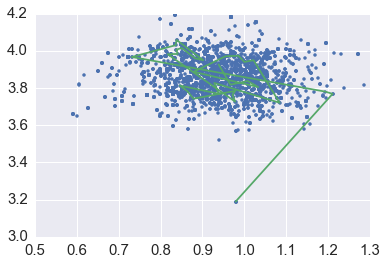

In [33]:
plt.plot(samples[1:M,0], samples[1:M,3], ".")
plt.plot(samples[1:50,0], samples[1:50,3])
